## Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style('darkgrid')

In [3]:
def print_score(Y_test, Y_pred):
    mae = mean_absolute_error(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    print(f'MAE : {mae:.2f}')
    print(f'MAPE : {100*mape:.2f}%')
    print(f'MSE : {mse:.0f}')

In [4]:
def get_date_opening_concu(row):
    year = int(row.CompetitionOpenSinceYear)
    month = int(row.CompetitionOpenSinceMonth)
    return pd.Timestamp(year=year, month=month, day=1)

In [5]:
def get_has_concu_since(row):
    date1 = pd.Timestamp(row.Date)
    date2 = row.date_concu
    return max((date1 - date2).days, 0)

In [6]:
def get_year(date):
    return int(date.split('-')[0])

def get_month(date):
    return int(date.split('-')[1])

def get_day(date):
    return int(date.split('-')[2])

## Data preparation

In [7]:
## Import data

data_path = 'data'
df_store = pd.read_csv(os.path.join(data_path, 'store.csv'))
df_train = pd.read_csv(os.path.join(data_path, 'train.csv'), low_memory=False)

In [8]:
# add date columns
df_train['Year'] = df_train['Date'].apply(lambda date: get_year(date))
df_train['Month'] = df_train['Date'].apply(lambda date: get_month(date))
df_train['Day'] = df_train['Date'].apply(lambda date: get_day(date))

In [9]:
# get date_concu for each store (the date where a concurrent has been created)
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].fillna('2023')
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].fillna('12')
df_store['date_concu'] = df_store.apply(lambda row : get_date_opening_concu(row), axis=1)
df_store.CompetitionDistance = df_store.CompetitionDistance.fillna(df_store.CompetitionDistance.max())

# keep only interesting columns
columns = ['Store', 'StoreType', 'Assortment', 'date_concu', 'CompetitionDistance']
df_store_reduced = df_store[columns]

In [10]:
df_tot = df_train.merge(df_store_reduced, on='Store')


In [11]:
len(df_tot)

1017209

In [12]:
df_tot = df_train.merge(df_store_reduced, on='Store')
# we don't want to predict when the store is closed (sales=0), the client must know the closing days
df_tot = df_tot[df_tot.Open==1]

In [13]:
len(df_tot)

844392

### Data exploration

In [16]:
df_tot.Sales.mean()

6955.514290755952

In [17]:
df_tot.Date.max()

'2015-07-31'

In [18]:
df_tot.Date.min()

'2013-01-01'

#### Seasonality features 

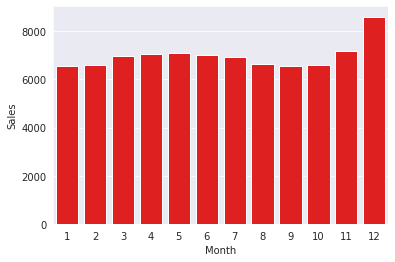

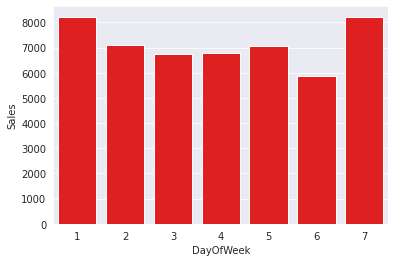

In [19]:
tmp = df_tot.groupby('Month')['Sales'].mean().reset_index()
sns.barplot(data=tmp, x='Month',y='Sales', color='red')
plt.show()

tmp = df_tot.groupby('DayOfWeek')['Sales'].mean().reset_index()
sns.barplot(data=tmp, x='DayOfWeek',y='Sales', color='red')
plt.show()

#### Features on the store type

Magasins qui génèrenent le plus d'argent VS le moins

In [20]:
df_tot.groupby('Store').Sales.mean().reset_index().sort_values(by='Sales').head(3)

,Store,Sales
306,307,2703.736573
542,543,2790.380282
197,198,2900.604859


In [21]:
df_tot.groupby('Store').Sales.mean().reset_index().sort_values(by='Sales').tail(3)

,Store,Sales
1113,1114,20666.562500
261,262,20718.515924
816,817,21757.483418


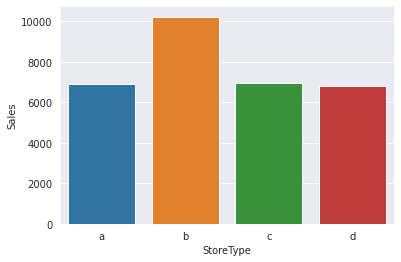

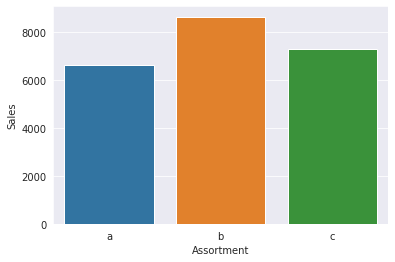

In [22]:
tmp = df_tot.groupby("StoreType").Sales.mean().reset_index()
sns.barplot(data=tmp, y='Sales', x='StoreType')
plt.show()

tmp = df_tot.groupby("Assortment").Sales.mean().reset_index()
sns.barplot(data=tmp, y='Sales', x='Assortment')
plt.show()

#### Features on promo offer

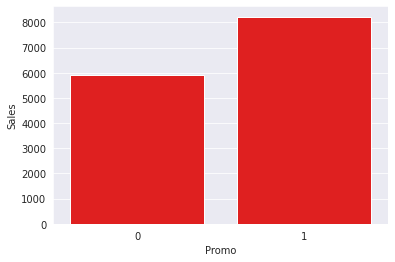

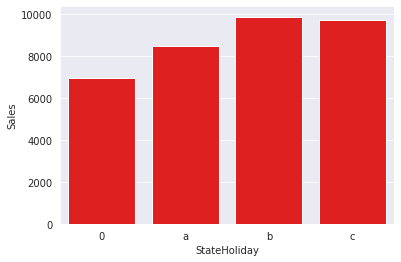

In [23]:
tmp = df_tot.groupby('Promo')['Sales'].mean().reset_index()
sns.barplot(data=tmp, x='Promo',y='Sales', color='red')
plt.show()

tmp = df_tot.groupby('StateHoliday')['Sales'].mean().reset_index()
sns.barplot(data=tmp, x='StateHoliday',y='Sales', color='red')
plt.show()

#### Features about concurrency

In [24]:
# difference between the current day and the day where the concurrence has been created, in days
df_tot['has_concu_since'] = df_tot.apply(lambda row: get_has_concu_since(row), axis=1)

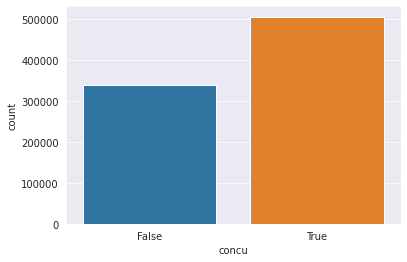

In [25]:
df_tot['concu'] = df_tot.has_concu_since > 0
sns.countplot(data=df_tot, x='concu')
plt.show()

In [26]:
no_concu = df_tot[df_tot.concu==False].groupby('Store').agg({'Sales':'mean', 'CompetitionDistance':'mean'}).reset_index()
no_concu = no_concu.rename(columns={"Sales":'Sales_no_concu'})

concu = df_tot[df_tot.concu==True].groupby('Store').Sales.mean().reset_index()
concu = concu.rename(columns={"Sales":'Sales_concu'})

In [27]:
tmp = no_concu.merge(concu)
tmp['delta'] = -(tmp['Sales_no_concu'] - tmp['Sales_concu'])
tmp['percent_lose_since_concu'] = tmp['delta'] / tmp['Sales_no_concu']
tmp.sort_values('delta')

,Store,Sales_no_concu,CompetitionDistance,Sales_concu,delta,percent_lose_since_concu
93,523,18330.909804,50.0,14180.742911,-4150.166893,-0.226403
146,882,9302.906667,30.0,6316.046110,-2986.860557,-0.321067
164,983,11895.879310,40.0,8923.265258,-2972.614052,-0.249886
151,905,9790.864169,90.0,7001.042614,-2789.821555,-0.284941
184,1086,9451.220472,180.0,6822.480076,-2628.740397,-0.278138
...,...,...,...,...,...,...
2,7,7732.586667,24000.0,8931.445851,1198.859184,0.155040
3,8,5153.771107,7520.0,6358.155378,1204.384272,0.233690
111,608,8127.851852,18370.0,9369.968127,1242.116276,0.152822
24,122,5262.975000,58260.0,6581.173913,1318.198913,0.250466


In [28]:
tmp.percent_lose_since_concu.mean()

-0.022414730457580825

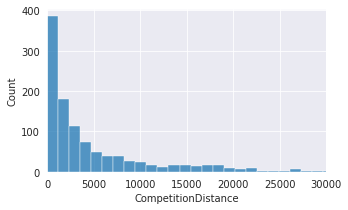

In [29]:
tmp = df_tot[df_tot.CompetitionDistance>0].groupby('Store')['CompetitionDistance'].mean().reset_index()
plt.figure(figsize=(5,3))
sns.histplot(data=tmp, x='CompetitionDistance')
plt.xlim(0, 30000)
plt.show()

### Create features

In [30]:
df_tot = df_tot.sort_values(by='Date')

In [31]:
df_tot.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'StoreType',
       'Assortment', 'date_concu', 'CompetitionDistance', 'has_concu_since',
       'concu'],
      dtype='object')

In [76]:
# Columns to keep
columns = ['Store', 'Month', 'Day', 'DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'has_concu_since',
          'SchoolHoliday', 'StateHoliday']
df_tot = df_tot[df_tot['Sales'] > 0]

X = df_tot[columns]
X = pd.get_dummies(X)

features_names = X.columns

Y = df_tot['Sales']

# We delete the lines where Sales = 0 (exception, and they will impact our MAPE metric)
#X = X[Y>0]
#Y = Y[Y>0]

In [77]:
df_tot[columns+['Sales']].sample(4)

,Store,Month,Day,DayOfWeek,Promo,StoreType,Assortment,CompetitionDistance,has_concu_since,SchoolHoliday,StateHoliday,Sales
37658,42,3,13,5,0,a,c,290.0,0,0,0,9501
446933,490,4,24,4,0,a,a,660.0,388,1,0,6172
730259,802,1,23,5,0,a,c,910.0,0,0,0,5556
757100,831,5,6,1,0,a,a,800.0,2166,0,0,11026


In [80]:
# Save our new dataset
X.to_csv('X.csv', sep=';')
Y.to_csv('Y.csv', sep=';')

In [81]:
X.head()

,Store,Month,Day,DayOfWeek,Promo,CompetitionDistance,has_concu_since,SchoolHoliday,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
615999,676,1,1,2,0,1410.0,1583,1,0,1,0,0,0,1,0,0,1,0,0
667669,733,1,1,2,0,860.0,4841,1,0,1,0,0,0,1,0,0,1,0,0
512659,562,1,1,2,0,1210.0,0,1,0,1,0,0,0,0,1,0,1,0,0
450995,494,1,1,2,0,1260.0,580,1,0,1,0,0,1,0,0,0,1,0,0
238339,262,1,1,2,0,1180.0,0,1,0,1,0,0,1,0,0,0,1,0,0


### Create train and test set

In [112]:
# Pour respecter le côté temporel
N= 5
n = len(X) // 5
X_train = X[:(N-1)*n]
X_test = X[(N-1)*n:]

Y_train = Y[:(N-1)*n]
Y_test = Y[(N-1)*n:]

In [113]:
# Si on s'en fout du coté temporel
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Souvent, quand on travaille avec des données temporelles, on prend dans le train les dates les plus anciennes, et dans le test les plus récentes, mais là ça a pas forcément d'intéret.

In [114]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, Y_train)
Y_pred = ridge.predict(X_test)
print_score(Y_test, Y_pred)

MAE : 1967.92
MAPE : 30.39%
MSE : 7585041


In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

rf = DecisionTreeRegressor()
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print_score(Y_test, Y_pred)

MAE : 1071.60
MAPE : 15.33%
MSE : 2765136


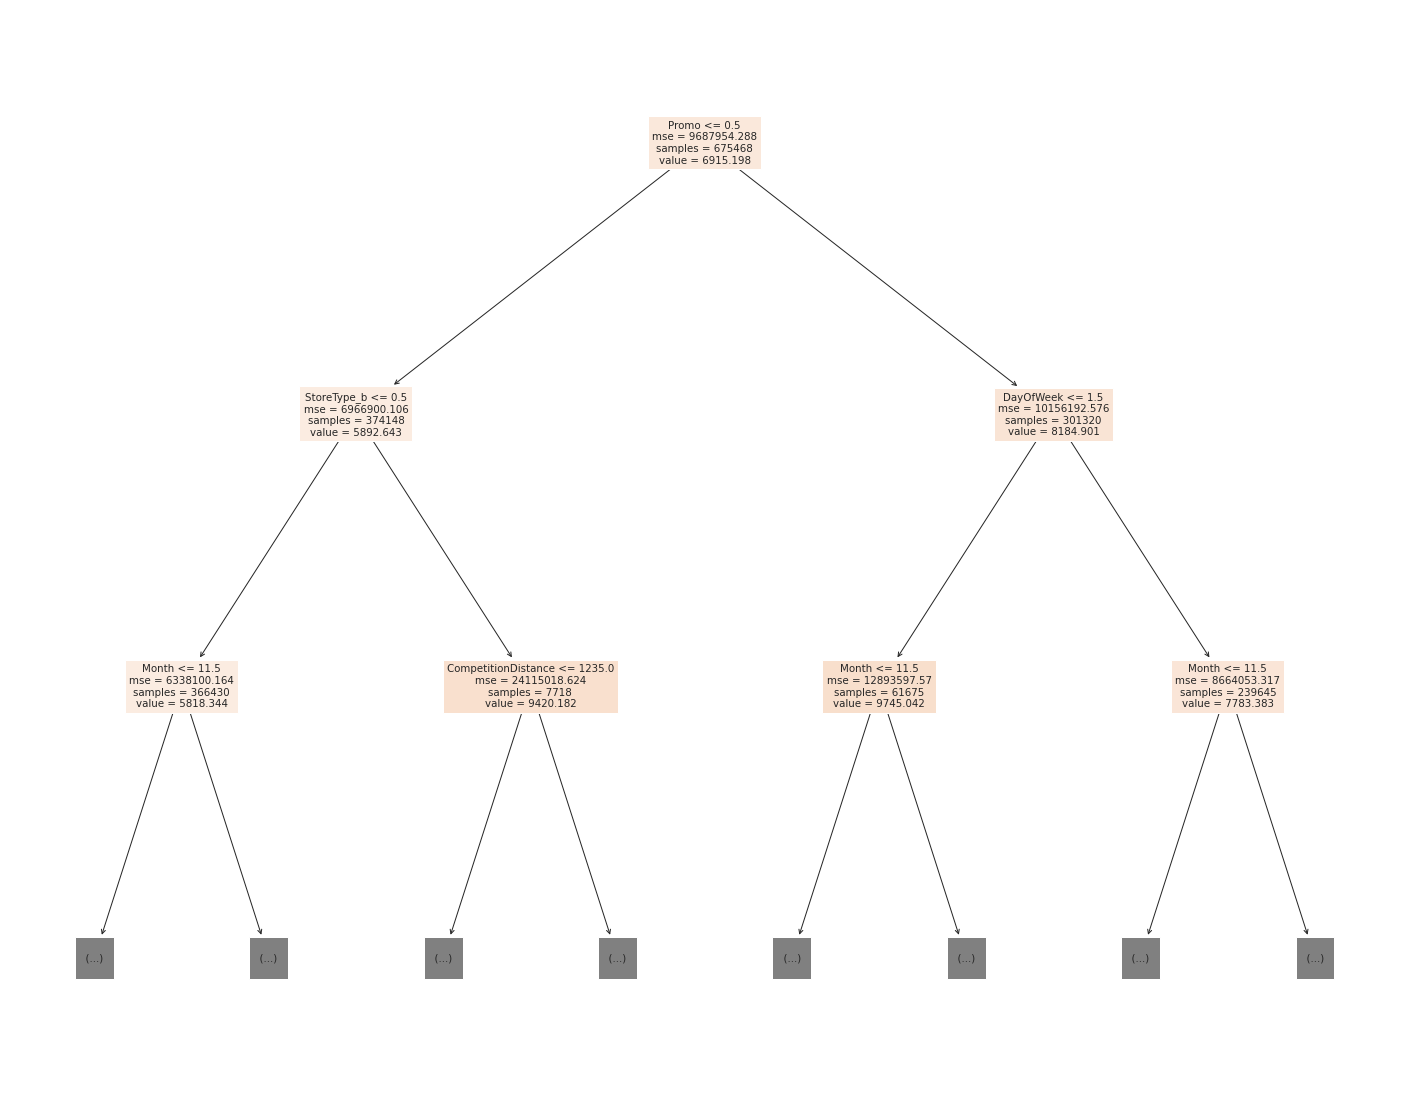

In [116]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(rf, feature_names=features_names, filled=True, max_depth=2)

In [117]:
rf = RandomForestRegressor(n_estimators=10, max_depth=30)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print_score(Y_test, Y_pred)

MAE : 847.80
MAPE : 12.09%
MSE : 1560695


<AxesSubplot:>

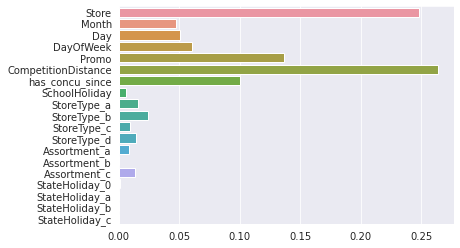

In [118]:
sns.barplot(x=rf.feature_importances_, y=features_names)

Perf

In [98]:
Y.mean()

6955.959133664481

In [119]:
df_tot['pred'] = rf.predict(X)

df_train= df_tot[:(N-1)*n].copy()
df_test = df_tot[(N-1)*n:].copy()
df_test['mae'] = np.abs(df_test['pred'] - df_test['Sales'])
df_test['mape'] = np.abs(df_test['pred'] - df_test['Sales']) / df_test['Sales']
df_test.mape.mean()

0.12086762053875946

In [120]:
tmp = df_test.groupby('Date').agg({'pred':'sum', 'Sales':'sum'}).reset_index()
tmp['mae'] = np.abs(tmp['pred'] - tmp['Sales'])
tmp['mape'] = np.abs(tmp['pred'] - tmp['Sales']) / tmp['Sales']
tmp.mape.mean()

0.06617110000902961

Scores of the 'Average Model'

In [121]:
moy_per_mag = df_train.groupby('Store').Sales.mean().reset_index()
moy_per_mag = moy_per_mag.rename(columns = {'Sales':'pred_avg'})
df_test = df_test.merge(moy_per_mag, on='Store')

df_test['mae_avg'] = np.abs(df_test['pred_avg'] - df_test['Sales'])
df_test['mape_avg'] = np.abs(df_test['pred_avg'] - df_test['Sales']) / df_test['Sales']
df_test.mape_avg.mean()

0.22052035274089493

In [122]:
df_test.mae_avg.mean()

1435.3336214955687

In [105]:
tmp = df_test.groupby('Date').agg({'pred_avg':'sum', 'Sales':'sum'}).reset_index()
tmp['mae'] = np.abs(tmp['pred_avg'] - tmp['Sales'])
tmp['mape'] = np.abs(tmp['pred_avg'] - tmp['Sales']) / tmp['Sales']
tmp.mape.mean()

0.15404172706683592

In [132]:
from datetime import timedelta

In [133]:
pd.to_datetime(df_tot.Date.max()) - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [134]:
df_tot[df_tot.Date > '2015-07-19']

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,StoreType,Assortment,date_concu,CompetitionDistance,has_concu_since,pred
212343,235,1,2015-07-20,5509,499,1,0,0,0,2015,7,20,a,a,2012-03-01,5710.0,1236,4611.749647
873375,959,1,2015-07-20,7372,824,1,0,0,1,2015,7,20,a,c,2005-12-01,1060.0,3518,6088.888060
501551,551,1,2015-07-20,6544,1025,1,0,0,1,2015,7,20,a,c,2013-09-01,2190.0,687,6880.789186
563009,618,1,2015-07-20,6691,512,1,0,0,0,2015,7,20,d,c,2023-12-01,9910.0,0,5837.422060
361635,397,1,2015-07-20,5148,737,1,0,0,1,2015,7,20,a,c,2023-12-01,130.0,0,4150.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718008,789,5,2015-07-31,4205,533,1,1,0,1,2015,7,31,a,c,2003-07-01,9770.0,4413,6861.400000
248518,274,5,2015-07-31,6975,1374,1,1,0,1,2015,7,31,b,b,2023-12-01,3640.0,0,3701.900000
247576,273,5,2015-07-31,9189,792,1,1,0,1,2015,7,31,a,c,2023-12-01,8480.0,0,9050.108159
630704,693,5,2015-07-31,8040,571,1,1,0,1,2015,7,31,d,a,2023-12-01,450.0,0,8761.900000


In [135]:
12275 / len(df_tot)

0.014538016765797584